In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import tensorflow_datasets as tfds
from keras.models import Model
from keras.utils import plot_model
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.regularizers import l2

In [ ]:
#Load tfds dataset
ds, info = tfds.load('oxford_flowers102', with_info=True, as_supervised=True)
test = ds['test']
train = ds['train']
validation = ds['validation']

#Dataset split sizes
train_size = train.cardinality()
print("Test size:", test.cardinality())
print("Train size", train_size)
print("Validation size", validation.cardinality())

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_flowers102/2.1.1.incompleteKAFUHK/oxford_flowers102-train.tfrecord*…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_flowers102/2.1.1.incompleteKAFUHK/oxford_flowers102-test.tfrecord*.…

Generating validation examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_flowers102/2.1.1.incompleteKAFUHK/oxford_flowers102-validation.tfre…

Dataset oxford_flowers102 downloaded and prepared to /root/tensorflow_datasets/oxford_flowers102/2.1.1. Subsequent calls will reuse this data.
Test size: tf.Tensor(6149, shape=(), dtype=int64)
Train size tf.Tensor(1020, shape=(), dtype=int64)
Validation size tf.Tensor(1020, shape=(), dtype=int64)


In [ ]:
#Number of flower classes
num_classes = info.features['label'].num_classes
print("Number of flower classes:", num_classes)

Number of flower classes: 102


In [ ]:
#Getting the shape of the images. None = varies in size in height and width. Depth = 3 meaning RGB 3 channel image
print(info.features['image'].shape)

(None, None, 3)


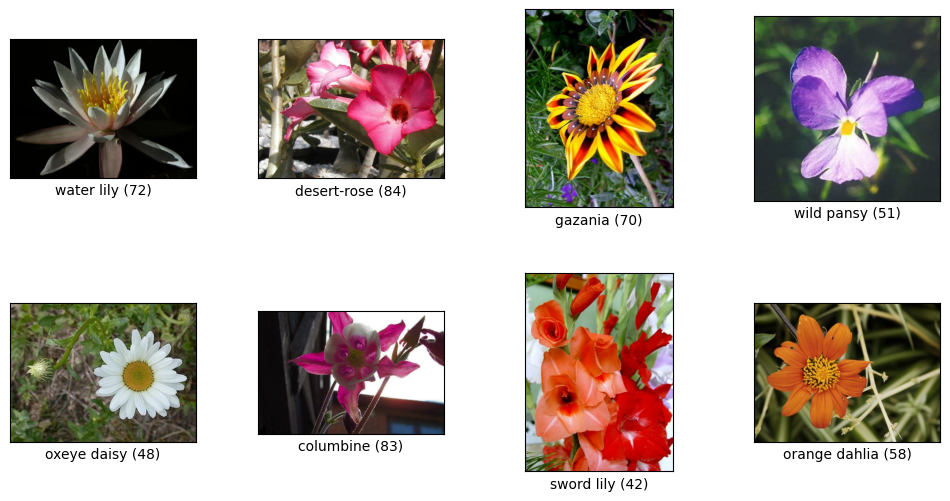

In [ ]:
#Showing some examples of the ds with varying image size and classes
print(tfds.show_examples(train, info, rows=2, cols=4))

In [ ]:
batch_size = 256
image_size = 128

def crop_and_resize_image(image, label):
  shape = tf.shape(image)
  #[-1] index is the image channel
  height = shape[-3]
  width = shape[-2]

  #takes shortest dimension and crops square
  if height > width:
      image = tf.image.crop_to_bounding_box(image, offset_height=(height - width) // 2, offset_width=0, target_height=width, target_width=width)
  else:
      image = tf.image.crop_to_bounding_box(image, offset_height=0, offset_width=(width - height) // 2, target_height=height, target_width=height)

  # shortest = tf.math.minimum(height, width)
  # image = tf.image.random_crop(image, (shortest, shortest, 3))

  #downsample image
  image = tf.image.resize(image, (image_size, image_size), antialias=True)/255.0
  return image, label

test_batches = test.map(crop_and_resize_image).batch(batch_size)
train_batches = train.cache().shuffle(train_size, reshuffle_each_iteration=True).repeat(60).map(crop_and_resize_image).batch(batch_size).prefetch(tf.data.AUTOTUNE)
validation_batches = validation.cache().map(crop_and_resize_image).batch(batch_size).prefetch(tf.data.AUTOTUNE)

Figure(1200x600)


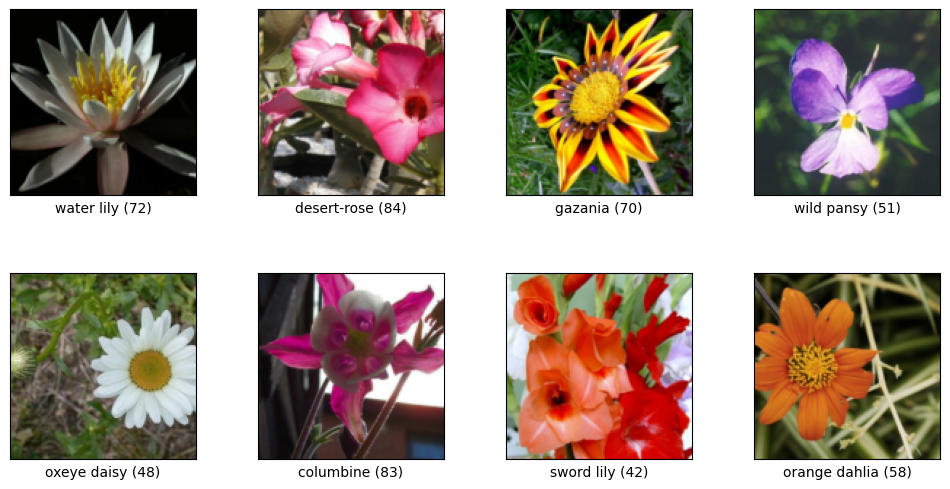

Figure(1200x600)


In [ ]:
#Showing some examples of the cropped and resized ds
temp = train.cache().map(crop_and_resize_image)
print(tfds.show_examples(temp, info, rows=2, cols=4))

In [ ]:
#Data augmentation
data_augmentation = keras.Sequential([
  layers.RandomContrast(0.5),
  layers.RandomBrightness(0.2, value_range=(0, 1)),
  layers.RandomFlip("horizontal_and_vertical"),
  # layers.RandomTranslation(0.2, 0.2, fill_mode='reflect'),
  # layers.RandomZoom(0.3, fill_mode='reflect'),
  layers.RandomRotation(0.2)
])

In [ ]:
# #Defining our model with its layers
# model = keras.Sequential([
#     data_augmentation,
#     layers.Conv2D(16, 3, strides=1, padding='same', activation='relu', kernel_constraint=max_norm(3.)),
#     layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid'),
#     layers.Conv2D(32, 3, strides=1, padding='same', activation='relu', kernel_constraint=max_norm(3.)),
#     layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid'),
#     layers.Conv2D(64, 3, strides=1, padding='same', activation='relu', kernel_constraint=max_norm(3.)),
#     layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid'),
#     layers.Flatten(),
#     layers.Dense(1024, activation='relu', kernel_constraint=max_norm(3.)),
#     layers.Dropout(0.5),
#     layers.Dense(num_classes, activation='softmax')
# ])

In [ ]:
#Resnet model
def residual(input_layer, n_filters, downsample):
  input = input_layer
  if input.shape[-1] != n_filters:
    input = layers.Conv2D(n_filters, (1,1), strides=(2 if downsample else 1), padding='same', activation='relu', kernel_initializer='he_normal')(input_layer)

  conv1 = layers.Conv2D(n_filters, (3,3), strides=(2 if downsample else 1), padding='same', activation='relu', kernel_initializer='he_normal', kernel_regularizer=l2(0.0001))(input_layer)
  conv1 = layers.BatchNormalization()(conv1)

  conv2 = layers.Conv2D(n_filters, (3,3), padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(0.0001))(conv1)

  output_layer = layers.Add()([conv2, input])
  output_layer = layers.Activation('relu')(output_layer)
  conv2 = layers.BatchNormalization()(conv2)
  return output_layer

def create_residual_model(initial_filters, block_set):
  input_layer = layers.Input(shape=(image_size, image_size, 3))
  n_filters = initial_filters

  x = input_layer
  x = layers.Conv2D(64, (7, 7), strides=2)(x)
  x = layers.MaxPooling2D((3, 3), strides=2)(x)
  for i in range(len(block_set)):
    num_blocks = block_set[i]
    for j in range(num_blocks):
      x = residual(x, n_filters, j==0 and i!=0)
    n_filters = n_filters * 2

  residual_model = Model(inputs=input_layer, outputs=x)
  return residual_model

model = keras.Sequential([
    data_augmentation,
    create_residual_model(64, [2, 2, 2, 2]),
    layers.GlobalAveragePooling2D(),
    layers.Flatten(),
    layers.Dense(num_classes, activation='softmax')
])

In [ ]:
#Compiles our model
model.compile(
  optimizer=keras.optimizers.Adam(learning_rate=0.001),
  loss=keras.losses.SparseCategoricalCrossentropy(), #Sparse means labels can be integers rather than one-hot enocded
  metrics=['accuracy']
  )

In [ ]:
#Adding callbacks
callbacks = [
    #keras.callbacks.ModelCheckpoint(filepath='checkpoint.h5', save_best_only=True, monitor='val_loss'),
    #keras.callbacks.EarlyStopping(patience=5)
]

In [ ]:
#Train model and store results
num_epochs = 10
train_history = model.fit(x=train_batches, epochs=num_epochs, callbacks=callbacks, validation_data=validation_batches)

Epoch 1/10
957/957 [==============================] - 218s 205ms/step - loss: 2.3053 - accuracy: 0.5958 - val_loss: 4.5549 - val_accuracy: 0.3461
Epoch 2/10
957/957 [==============================] - 184s 193ms/step - loss: 0.9659 - accuracy: 0.9269 - val_loss: 4.7610 - val_accuracy: 0.4029
Epoch 3/10
957/957 [==============================] - 184s 192ms/step - loss: 0.8245 - accuracy: 0.9494 - val_loss: 4.7735 - val_accuracy: 0.4059
Epoch 4/10
957/957 [==============================] - 183s 191ms/step - loss: 0.7360 - accuracy: 0.9588 - val_loss: 4.9347 - val_accuracy: 0.3784
Epoch 5/10
957/957 [==============================] - 184s 192ms/step - loss: 0.6870 - accuracy: 0.9611 - val_loss: 4.5589 - val_accuracy: 0.4431
Epoch 6/10
957/957 [==============================] - 183s 191ms/step - loss: 0.6104 - accuracy: 0.9706 - val_loss: 4.4498 - val_accuracy: 0.4471
Epoch 7/10
957/957 [==============================] - 185s 193ms/step - loss: 0.5910 - accuracy: 0.9700 - val_loss: 4.7494 -

In [ ]:
model.evaluate(test_batches)

97/97 [==============================] - 25s 255ms/step - loss: 5.4809 - accuracy: 0.4014


[5.4808526039123535, 0.40136608481407166]

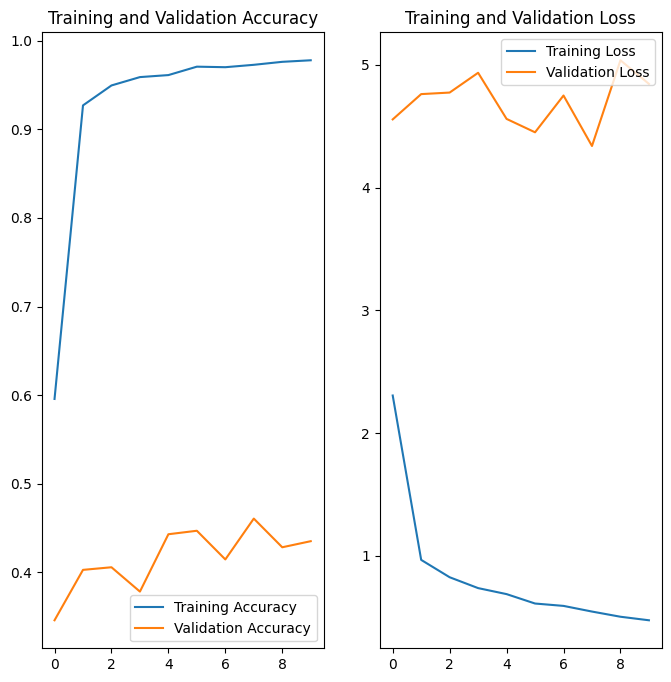

In [ ]:
# Creating plots of the loss of accuracy on the training and validation sets
acc = train_history.history['accuracy']
val_acc = train_history.history['val_accuracy']
loss = train_history.history['loss']
val_loss = train_history.history['val_loss']

epochs_range = range(num_epochs)

# Training and Validation Accuracy
plt.figure(figsize = (8,8))
plt.subplot(1,2,1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Training and Validation Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

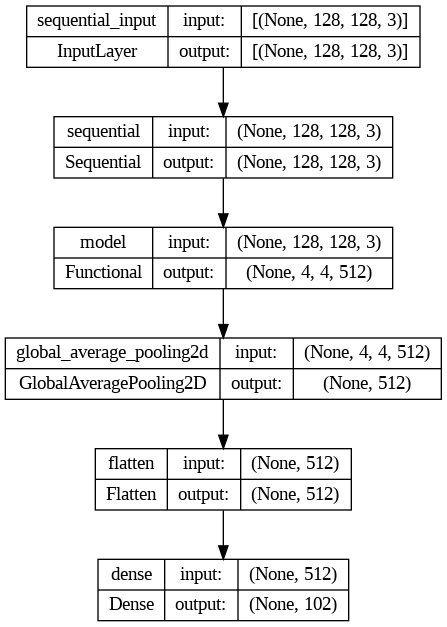

In [ ]:
plot_model(model, show_shapes=True, to_file='residual_module.png')

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 128, 128, 3)       0         
                                                                 
 model (Functional)          (None, 4, 4, 512)         11179392  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 102)               52326     
                                                                 
Total params: 11,231,718
Trainable params: 11,227,878
Non-trainable params: 3,840
______________________________________